#Scripts de PyPlot para hacer figuras chingonas para poster

Primero, vamos a intentarlo con un experimento que tenga una actividad notoria. Aquí cargamos un archivo que contiene los datos de un experimento con actividad epiléptica. La región CA aparece muy activa varias veces en las mediciones del potencial de campo local, LFP de ahora en adelante.

In [1]:
using PyPlot

libGL error: failed to open drm device: Permiso denegado
libGL error: failed to load driver: i965
INFO: Loading help data...


In [2]:
muacamuaca=open("../Actividad4AP/DatosActividadEpilepticaSelectos.bin", "r")
formaarray=(64,64,5001)
DatosExperimentales=read(muacamuaca, Float64, formaarray);
close(muacamuaca)

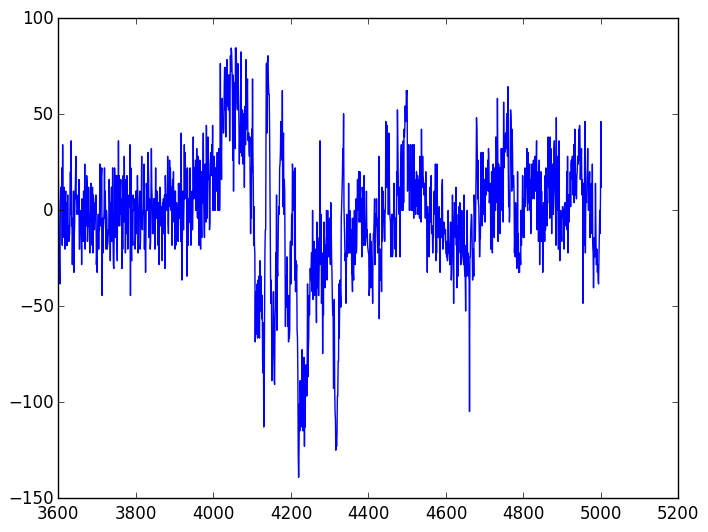

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff3ecc68e80>

In [3]:
#No todos los datos son interesantes
ion()
intervalo=3600:5001
plot(intervalo, vec(DatosExperimentales[52,40,intervalo]))

Por consistencia, vamos a transponer todos los datos para que las imagenes coincidan con las de Franco

In [7]:
DatosExperimentales=DatosExperimentales[:,:,intervalo];
(alto,ancho,tmax)=size(DatosExperimentales)
map!(x-> abs(x)>1750? 0: x, DatosExperimentales);


LoadError: BoundsError()
while loading In[7], in expression starting on line 1

In [5]:
for t=1:tmax
    DatosExperimentales[:,:,t]=transpose(DatosExperimentales[:,:,t])
end

In [6]:
function ListaPixelesdeLinea(x::Array, y::Array)
    #obtener una lista de pixeles/electrodos a lo largo de una linea con dos endpoints enteros.
    #Se ponen las dos coordenadas x en un arreglo y las dos y en otro-
    xuno, xdos=x[1], x[2]
    yuno, ydos=y[1],y[2]
    longitud=abs(xuno-xdos)
    m=(ydos-yuno)/(xdos-xuno)
    xresult=[xuno:xdos] #asumimos que el xdos es el grande!
    yresult=zeros(Int, longitud+1)
    for j in 1:longitud+1
        yresult[j]=int(yuno+(j-1)*m)
    end
    return (xresult,yresult)
end

ListaPixelesdeLinea (generic function with 1 method)

In [8]:
puntox=[44,48,52,54,58, 63]
puntoy=[38,42,45,47,50, 54]
puntoy=puntoy+3
puntol=["F","E", "D", "C", "B","A"];
primax=[32, 32, 32, 32, 32, 32]
primay=[43,47,51,55,59,63]
primal=["F'","E'", "D'", "C'", "B'","A'"];

In [9]:
muchasx,muchasy=ListaPixelesdeLinea([44,63],[38,28])

([44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63],[38,37,37,36,36,35,35,34,34,33,33,32,32,31,31,30,30,29,29,28])

In [10]:
dobleprimax=[44,48,52,54,58,62]
dobleprimay=[38,36,34,32,30,28]
dobleprimal=["F''","E''", "D''", "C''", "B''","A''"];

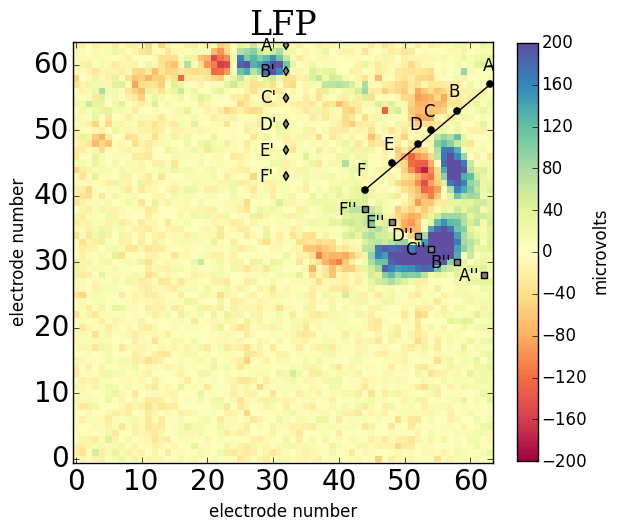

PyObject <matplotlib.text.Text object at 0x7ff3ecc58240>

In [11]:
figure(figsize=(6.0,5.5))
font1 = ["family"=>"DejaVu Serif",
    "color"=>"black",
    "weight"=>"normal",
    "size"=>24]

title("LFP", fontdict=font1)
limites=200
PyPlot.xlim(-0.5,63.5)
PyPlot.ylim(-0.5,63.5)

for punto in 1:6
    annotate(puntol[punto], (puntox[punto], puntoy[punto]), xytext=(-5,10), textcoords="offset points")
    annotate(primal[punto], (primax[punto], primay[punto]), xytext=(-18,-4), textcoords="offset points")
    annotate(dobleprimal[punto], (dobleprimax[punto], dobleprimay[punto]), xytext=(-18,-4), textcoords="offset points")
end
imagen=imshow((DatosExperimentales[:,:,550]), interpolation="none", cmap="Spectral", origin="lower", vmin=-limites, vmax=limites)
tick_params(axis="both", labelsize=20)

scatter(puntox,puntoy, marker="o", s=20, c="black")
scatter(primax,primay, marker="d", s=20, c="grey")
scatter(dobleprimax,dobleprimay, marker="s", s=20, c="grey")


plot([44, 63], [41, 57], "k-")

cbx=colorbar(imagen, fraction=0.045) 
cbx[:set_label]("microvolts")
tick_params(axis="both", labelsize=20)

xlabel("electrode number")
ylabel("electrode number")

#savefig("LFP_Recorded_550_electrodos_01.png", dpi=90)

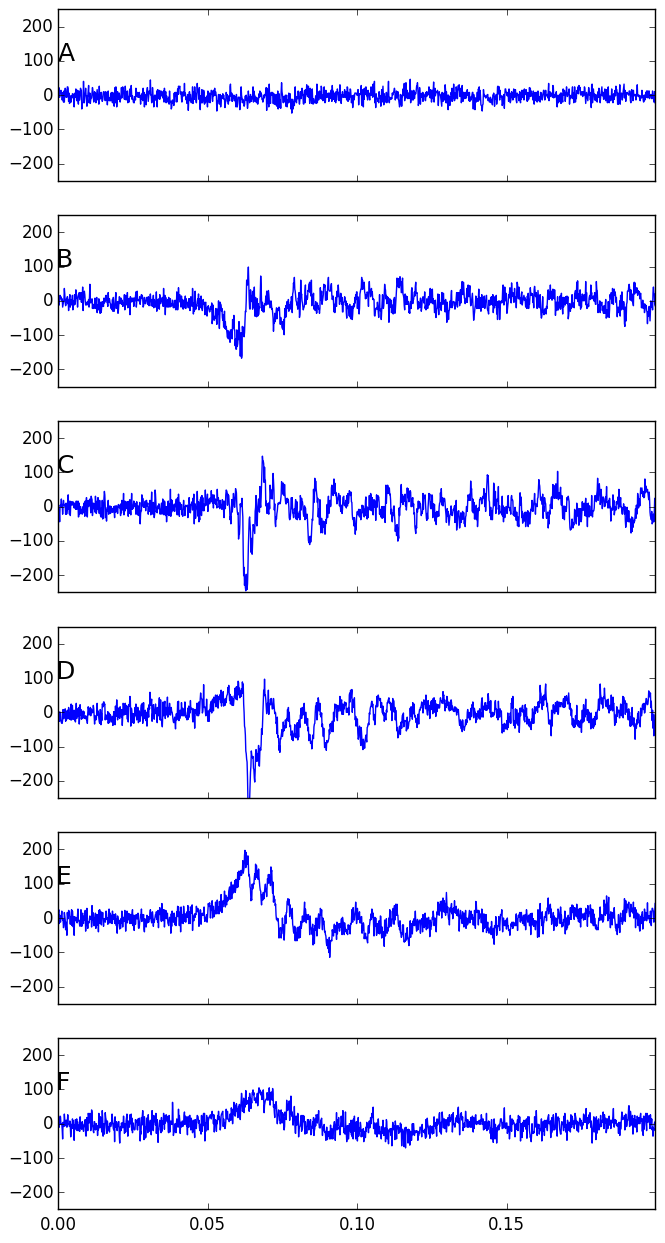

In [12]:
tiempo=1:tmax
t=700

farofa, lista=subplots(6, sharex=true, sharey=true, figsize=(7.7,6*2.5))

for j=1:6
    PyPlot.xlim(1/7022,tmax/7022)
    PyPlot.ylim(-250,250)
    lista[j][:plot](tiempo/7022,vec(DatosExperimentales[puntoy[7-j],puntox[7-j],tiempo]))
    lista[j][:annotate](puntol[7-j],xy=(0.0,100), annotation_clip=false, fontsize=18)
end


#savefig("LFP_A-F_Points_01.svg",dpi=90)

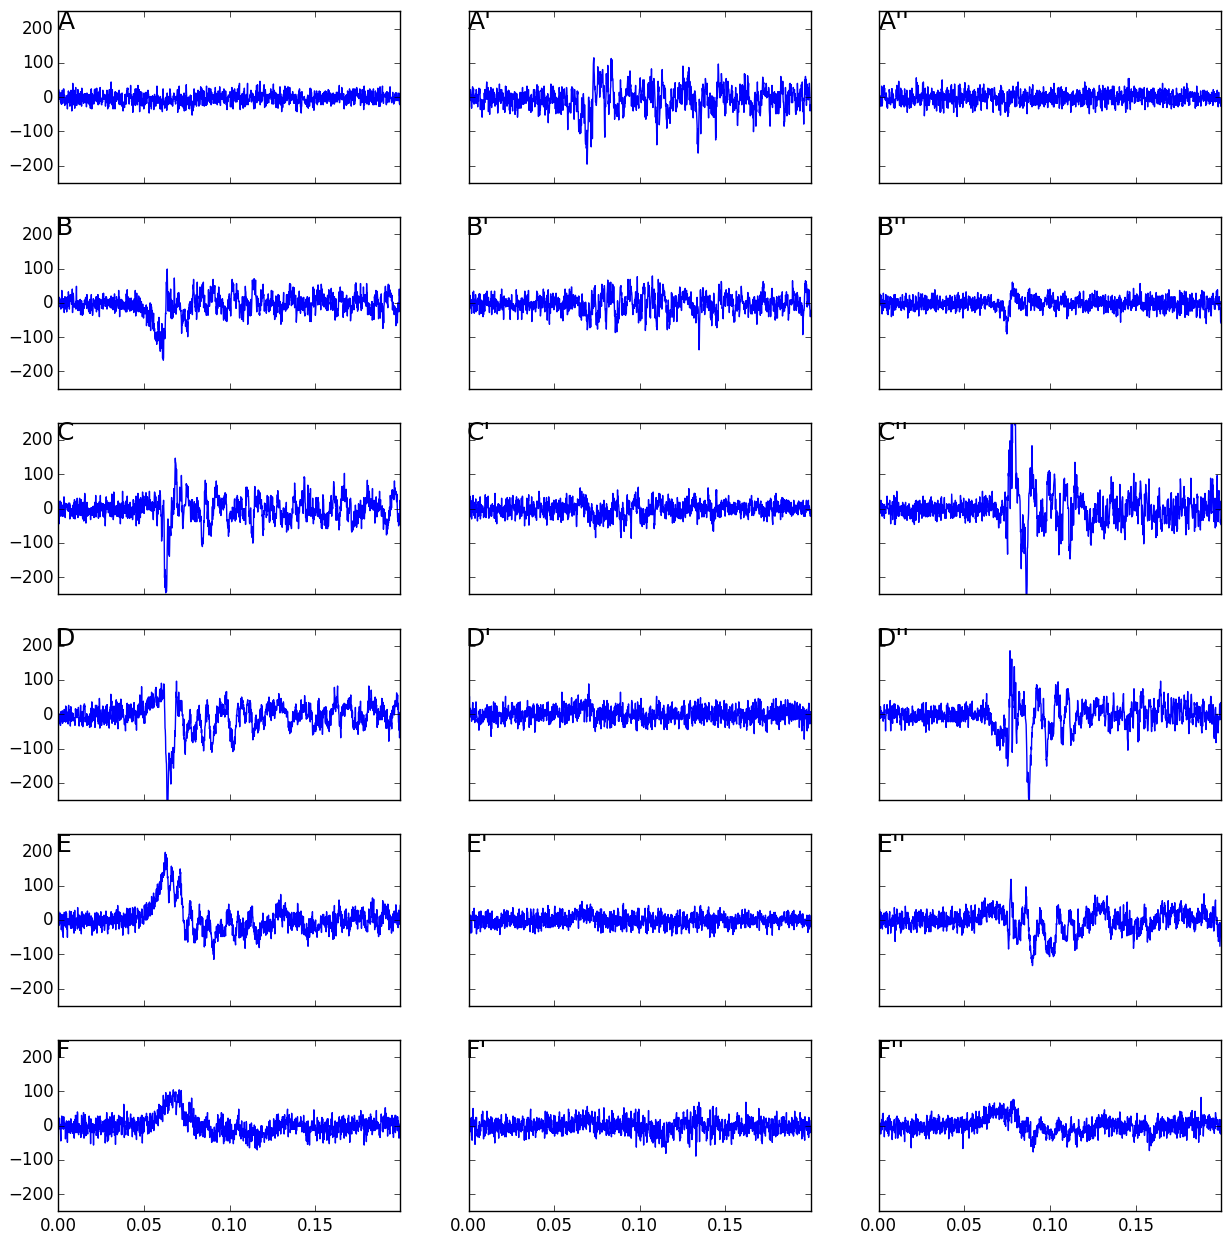

In [13]:
tiempo=1:tmax
t=700

farofa, lista=subplots(6,3, sharex=true, sharey=true, figsize=(15,6*2.5))

for j=1:6
    PyPlot.xlim(1/7022,tmax/7022)
    PyPlot.ylim(-250,250)
    lista[j,1][:plot](tiempo/7022,vec(DatosExperimentales[puntoy[7-j],puntox[7-j],tiempo]))
    lista[j,1][:annotate](puntol[7-j],xy=(0.0,200), annotation_clip=false, fontsize=18)
    
    lista[j,2][:plot](tiempo/7022,vec(DatosExperimentales[primay[7-j],primax[7-j],tiempo]))
    lista[j,2][:annotate](primal[7-j],xy=(0.00,200), annotation_clip=false, fontsize=18)
    
    lista[j,3][:plot](tiempo/7022,vec(DatosExperimentales[dobleprimay[7-j],dobleprimax[7-j],tiempo]))
    lista[j,3][:annotate](dobleprimal[7-j],xy=(0.0,200), annotation_clip=false, fontsize=18)
end

#savefig("LFP_A-F_yOtros_Points_01.svg",dpi=90)

In [14]:
xs=[44,63]
ys=[38,54]+3
(xxs,yys)=ListaPixelesdeLinea(xs,ys);


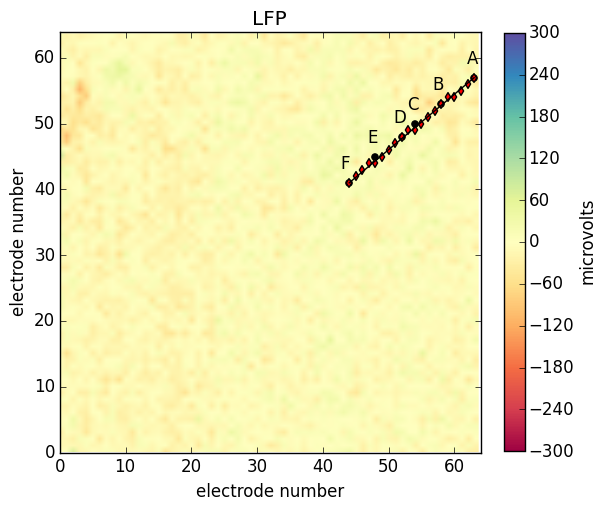

PyObject <matplotlib.text.Text object at 0x7ff3b3bf7198>

In [15]:
figure(figsize=(6,6.0))
title("LFP")
limites=300
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)

for punto in 1:6
    annotate(puntol[punto], (puntox[punto], puntoy[punto]), xytext=(-5,10), textcoords="offset points")
end
imagen=imshow((DatosExperimentales[:,:,350]), cmap="Spectral", origin="lower", vmin=-limites, vmax=limites)

scatter(puntox,puntoy, marker="o", s=20, c="black")
scatter(xxs,yys, marker="d", s=20, c="r")

plot([44, 63], [41, 57], "k-")

cbx=colorbar(imagen, fraction=0.045) 
cbx[:set_label]("microvolts")
xlabel("electrode number")
ylabel("electrode number")

#savefig("LFP_Recorded_350_with_selected_electrodes_01.png", dpi=90)

In [16]:
arregloparacascada=zeros(length(xxs),tmax);
for j in 1:length(xxs)
    arregloparacascada[j,:]=DatosExperimentales[xxs[j],yys[j],:]
end
writedlm("LFP_spaciotemporal_01.dat", transpose(arregloparacascada))

In [17]:
function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

function GaussSuavizar(Datos,Sigma)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3*sigma
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), [-medioancho:medioancho])
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)-medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    #nromalizacion 
    #result=result*a/b
    return result
end
    
GaussianKernel=readdlm("GaussianMatrix.dat")

function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #Esta convolución no respeta norma L2
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end

GaussianSmooth (generic function with 1 method)

In [20]:
LFPSuave=zeros(DatosExperimentales);
for j=1:64, k=1:64
    LFPSuave[j,k,:]=GaussSuavizar(reshape(DatosExperimentales[j,k,:],tmax),7)
end

In [21]:
LFPPlanchado=zeros(LFPSuave)
for t=1:tmax
    LFPPlanchado[:,:,t]=GaussianSmooth(LFPSuave[:,:,t])
end

In [18]:
writedlm("LFP4AP_Planchado_01.dat", LFPPlanchado)

In [21]:
arregloparacascadaLFP=zeros(length(xxs),tmax);
for j in 1:length(xxs)
    arregloparacascadaLFP[j,:]=LFPPlanchado[xxs[j],yys[j],:]
end
writedlm("LFPPlanchado_spaciotemporal_01.dat", transpose(arregloparacascadaLFP))

In [22]:
function DropPeques(data)
    #solo funciona con data de dos indices.
    renglones,colus=size(data)
    prom=mean(abs(data[3]))
    result=zeros(1,colus)
    for k=1:renglones
        if abs(data[k,3])>prom
            result=vcat(result,data[k,:])
        end
    end
    return result
end

DropPeques (generic function with 1 method)

In [23]:
LaplacianTerm1=[[0 1 0], [1 -4 1], [0 1 0]]
LaplacianTerm2=[[0.5 0 0.5], [0 -2 0], [0.5 0 0.5]]
LaplacianKernel=(1-1/3)*LaplacianTerm1+(1/3)*LaplacianTerm2

function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo+1, k=2:ancho+1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    return result
end

DiscreteLaplacian (generic function with 1 method)

In [24]:
CSDPlanchada=zeros(LFPPlanchado)
for t=1:tmax
    CSDPlanchada[:,:,t]=-DiscreteLaplacian(LFPPlanchado[:,:,t])
end

In [26]:
#Tambien un arreglo para cascada del CSD
arregloparacascadacsd=zeros(arregloparacascada)
for j in 1:length(xxs)
    arregloparacascadacsd[j,:]=CSDPlanchada[xxs[j],yys[j],:]
end
#writedlm("CSDPlanchado_spaciotemporal_01.dat", transpose(arregloparacascada))

In [27]:
limites=40
figure(figsize=(8,3))
picts=imshow(arregloparacascadaLFP, cmap="Spectral", vmin=-limites, vmax=limites)
tiempoestampas=axes()[:get_xticks]()
map!(x->round(x/7.0224,1), tiempoestampas)
axes()[:set_xticklabels](tiempoestampas)
profundidadestampas=axes()[:get_yticks]()
map!(x->round(x/19*1.04,1), profundidadestampas)
axes()[:set_yticklabels](profundidadestampas)
xlabel("time (ms)")
ylabel("distance along A-F line (mm)")
axes()[:set_aspect](20)

annotate("A",
    xy=[-0.02;0.95],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=20.0,
    ha="left",
    va="bottom")


annotate("F",
    xy=[-0.02, -0.2],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=20.0,
    ha="left",
    va="bottom")

#savefig("LFP-AF_timespace01.svg", dpi=90)

LoadError: arregloparacascadaLFP not defined
while loading In[27], in expression starting on line 3

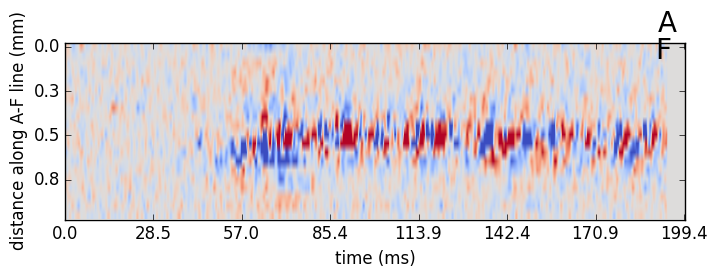

In [28]:
limites=20
figure(figsize=(8,3))

picts=imshow(arregloparacascadacsd, cmap="coolwarm",vmin=-limites, vmax=limites)
tiempoestampas=axes()[:get_xticks]()
map!(x->round(x/7.0224,1), tiempoestampas)
axes()[:set_xticklabels](tiempoestampas)
profundidadestampas=axes()[:get_yticks]()
map!(x->round(x/19*1.04,1), profundidadestampas)
axes()[:set_yticklabels](profundidadestampas)
xlabel("time (ms)")
ylabel("distance along A-F line (mm)")
axes()[:set_aspect](20)

annotate("A",
    xy=[-0.02;0.95],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=20.0,
    ha="left",
    va="bottom")


annotate("F",
    xy=[-0.02, -0.2],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=20.0,
    ha="left",
    va="bottom")

savefig("CSD-AF_timespace01.svg", dpi=90)

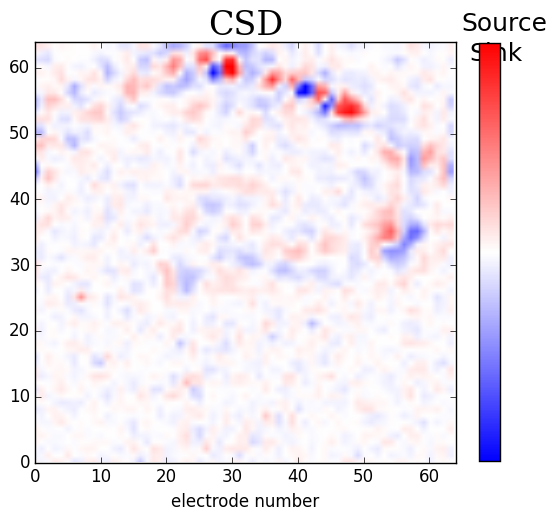

false

In [41]:
PyPlot.ion()
#################
font1 = ["family"=>"DejaVu Serif",
    "color"=>"black",
    "weight"=>"normal",
    "size"=>24]


t=850
seg=round(t/7022, 4)
titulo="$seg s"
figure(figsize=(6,5.5))
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)
#tick_params(labelbottom="off", labelleft="off")
otraimagen=imshow(CSDPlanchada[:,:,t], cmap="bwr", origin="lower", vmin=-50, vmax=50)
#cb=colorbar(otraimagen)
#cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04, use_gridspace='True')
cb=colorbar(otraimagen, ticks=[-150, +150], use_gridspec="True",fraction=0.045 )
#farofa=cb[:set_ticklabels]([{"Sink"}, {"Source"}])
#xlabel("furufu", fontdict=font1)


annotate("Sink",
    xy=[1.07;-0.09],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=18.0,
    ha="left",
    va="bottom")

annotate("Source",
    xy=[1.05;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=18,
    ha="left",
   va="bottom")

xlabel("electrode number")

title("CSD", fontdict=font1)

 savefig("CSDPlanchada-$t.png", dpi=90)

#tight_layout()

PyPlot.close_queued_figs()

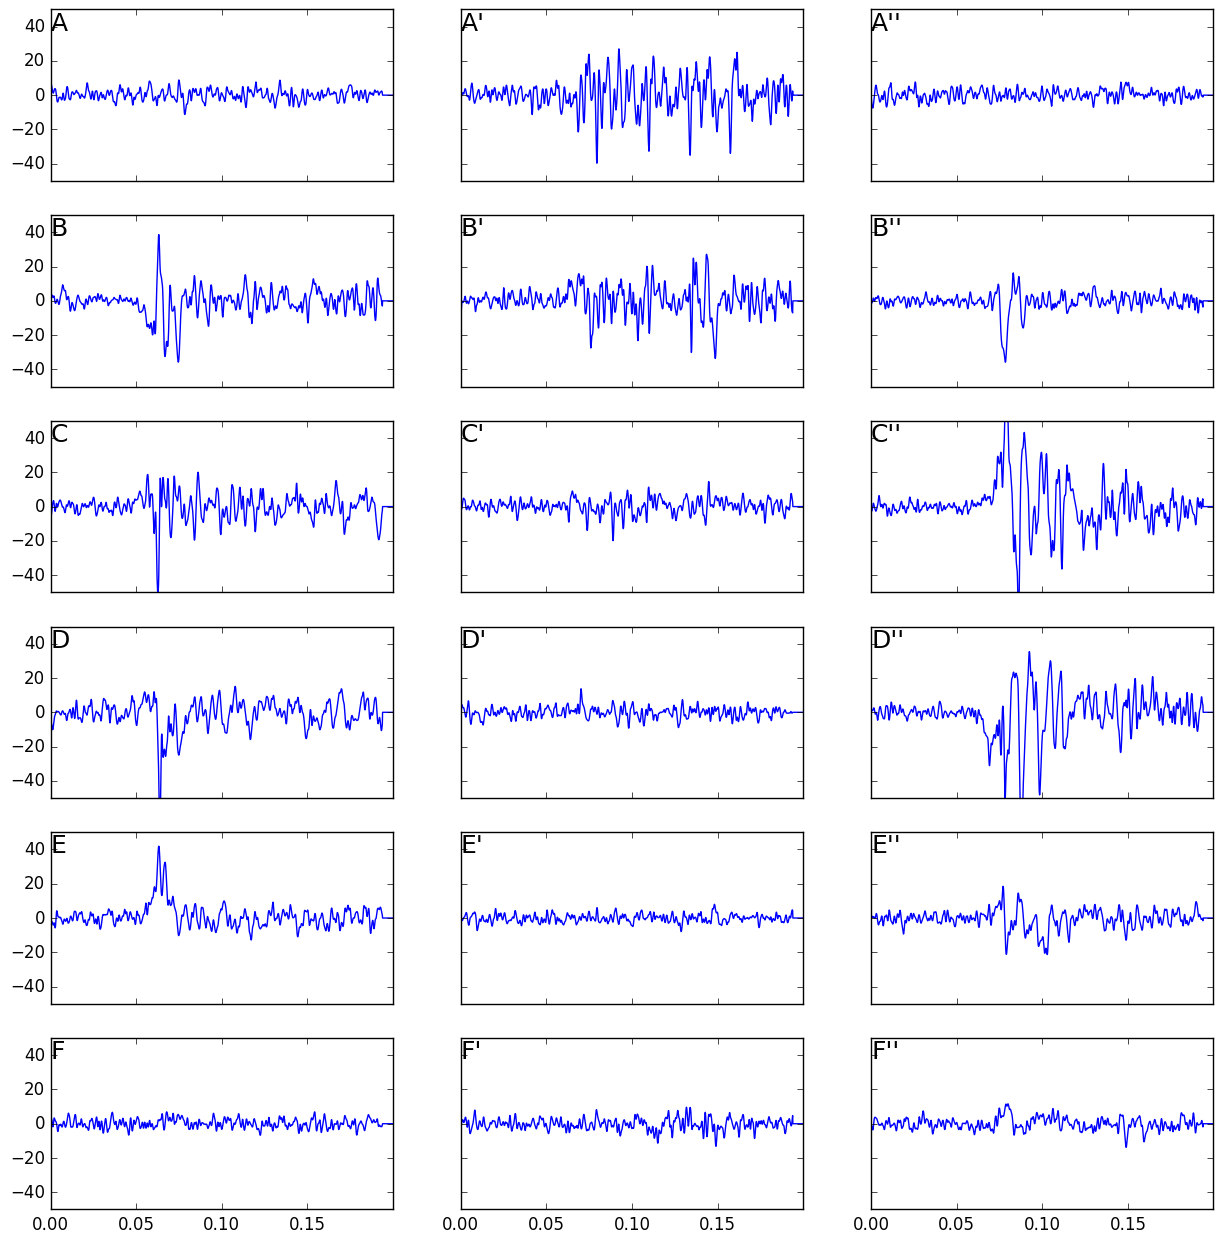

In [52]:
tiempo=1:tmax
t=700


farofa, lista=subplots(6,3, sharex=true, sharey=true, figsize=(15,6*2.5), frameon="false")

for j=1:6
    PyPlot.xlim(1/7022,tmax/7022)
    PyPlot.ylim(-50,50)
    lista[j,1][:plot](tiempo/7022,vec(CSDPlanchada[puntoy[7-j],puntox[7-j],tiempo]))
    lista[j,1][:annotate](puntol[7-j],xy=(0.0,38), annotation_clip=false, fontsize=18)
    
    lista[j,2][:plot](tiempo/7022,vec(CSDPlanchada[primay[7-j],primax[7-j],tiempo]))
    lista[j,2][:annotate](primal[7-j],xy=(0.00,38), annotation_clip=false, fontsize=18)
    
    lista[j,3][:plot](tiempo/7022,vec(CSDPlanchada[dobleprimay[7-j],dobleprimax[7-j],tiempo]))
    lista[j,3][:annotate](dobleprimal[7-j],xy=(0.0,38), annotation_clip=false, fontsize=18)
end

savefig("CSD_A-F_yOtros_Points_01.svg",dpi=90)

In [34]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end

function DropPeques(data)
    #solo funciona con data de dos indices.
    renglones,colus=size(data)
    prom=mean(abs(data[3]))
    result=zeros(1,colus)
    for k=1:renglones
        if abs(data[k,3])>prom
            result=vcat(result,data[k,:])
        end
    end
    return result
end

DropPeques (generic function with 1 method)

In [35]:
function ObtenComponentesYEscribe(Datos::Array, tini=1, tfini=tmax)

 for t=tini:tfini
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
    SpikeCountPositivo=zeros(64,64)
    SpikeCountNegativo=zeros(64,64)
    #Todos
    for j=1:64, k=1:64
            if(Datos[j,k,t]<-0.0)     
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
                elseif(Datos[j,k,t]>0.0)
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    listaneg=copy(ActividadNegativa)
    listapos=copy(ActividadPositiva)
    componentesneg=Set{Any}()
    componentespos=Set{Any}()
    #Primero lo negativo (pozos)
    while(length(listaneg)!=0)
        x=pop!(listaneg) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listaneg)
             #   
                    deleteat!(listaneg, indexin({v}, listaneg))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentesneg, componentecurlab)
    end


    centrosdemasaneg=[[0 0 0];]
    for p in componentesneg
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
                masalocal=Datos[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasaneg=vcat(centrosdemasaneg, A)
    end
    centrosdemasaneg=centrosdemasaneg[2:end,:]
    zacatlan="GarbageCollector/CMPozos-$t.dat"
    writedlm(zacatlan, centrosdemasaneg)
    ##### Ahora lo posittivo (fuentes)
    while(length(listapos)!=0)
        x=pop!(listapos) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listapos)
             #   
                    deleteat!(listapos, indexin({v}, listapos))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentespos, componentecurlab)
    end


    centrosdemasapos=[[0 0 0];]
    for p in componentespos
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
                masalocal=Datos[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasapos=vcat(centrosdemasapos, A)
    end
    centrosdemasapos=centrosdemasapos[2:end,:]
    zacatlan="GarbageCollector/CMFuentes-$t.dat"
    writedlm(zacatlan, centrosdemasapos)
end
    return curlab
end

ObtenComponentesYEscribe (generic function with 3 methods)

In [36]:
ObtenComponentesYEscribe(CSDPlanchada, 300, 2000)

LoadError: BoundsError()
while loading In[36], in expression starting on line 1

In [29]:
t=550
EjemploCentrosCSDPos=readdlm("GarbageCollector/CentrosDeMasaParaPoster/CMFuentes-550.dat")
EjemploCentrosCSDPos=DropPeques(EjemploCentrosCSDPos)
xxpos=EjemploCentrosCSDPos[:,1]
yypos=EjemploCentrosCSDPos[:,2]
valorpos=EjemploCentrosCSDPos[:,3]
EjemploCentrosCSDNeg=readdlm("GarbageCollector/CentrosDeMasaParaPoster/CMPozos-550.dat")
EjemploCentrosCSDNeg=DropPeques(EjemploCentrosCSDNeg)
xxneg=EjemploCentrosCSDNeg[:,1]
yyneg=EjemploCentrosCSDNeg[:,2]
valorneg=EjemploCentrosCSDNeg[:,3];
CSDEjemplo=CSDPlanchada[:,:,550];

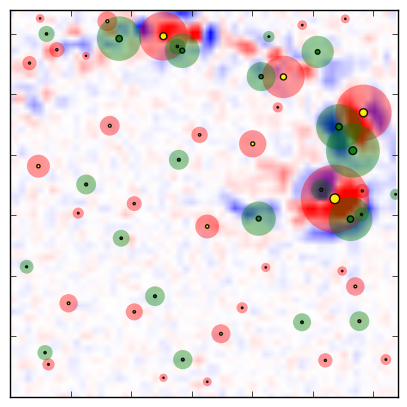

false

In [42]:
PyPlot.ion()
#################
font1 = ["family"=>"DejaVu Serif",
    "color"=>"black",
    "weight"=>"normal",
    "size"=>20]
seg=round(t/7022, 4)
titulo="$seg s"
figure(figsize=(5,5))
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)
tick_params(labelbottom="off", labelleft="off")
otraimagen=imshow(CSDEjemplo, cmap="bwr", origin="lower", vmin=-50, vmax=50)
#cb=colorbar(otraimagen)
#cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04, use_gridspace='True')
#cb=colorbar(otraimagen, ticks=[-150, +150], use_gridspec="True")
#farofa=cb[:set_ticklabels]([{"Sink"}, {"Source"}])
#xlabel("furufu", fontdict=font1)

scatter(xxpos,yypos, s=valorpos, alpha=0.4, c="r", edgecolors="none")
scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.4, c="g", edgecolors="none")
scatter(xxpos,yypos, s=0.02*valorpos, alpha=0.9, c="yellow", edgecolors="black")
scatter(xxneg, yyneg,s=0.02*abs(valorneg), alpha=0.9, c="green", edgecolors="black")


#title(titulo, fontdict=font1)
 #tight_layout()
savefig("CSDCM-discos-550.svg", dpi=90)
PyPlot.close_queued_figs()